In [30]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt

In [31]:
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p =  kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 1000 / koff
k_beta = koff 

p_scaled = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

print(Kd_scaled, kmax_scaled, kbasal_scaled)

0.478375 0.04203519639903277 8.080360096723108e-05


In [32]:
def khammash_ode_scaled(t,x,p_scaled,I):
    if callable(I):
        I = I(t)

    # Parameters
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = p_scaled

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])

    # k_alpha = kon / koff
    # k_beta = koff

    dTFondt = (I * k_alpha * (1 - TFon) - TFon) * k_beta
    # dTFondt = I * kon * (1 - TFon) - koff * TFon
    dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA

    return [dTFondt, dmRNAdt]


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - (TFon  * TFtot)) - koff * (TFon  * TFtot)
    dmRNAdt = kbasal + kmax * ((TFon  * TFtot) ** n) / ((Kd ** n) + ((TFon  * TFtot) ** n)) - kdegR * mRNA

    dTFondt = dTFondt / TFtot
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,-1] - x[:])
    return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def fsolve_func_scaled(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    return (sol.y[:,-1] - x[:])
    # return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    # try:
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
    # except:
    #     print('first one failed')
    #     x_guess = [u,u]
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
    # steady = sol


    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)
    if not sol.success:
        x_guess = [u,u]
        sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)

    steady = np.maximum(sol.x,[0,0])
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=steady, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    steady = np.trapz(sol.y, x=sol.t) / period

    return steady#, sol.success, sol.message, sol.fun

def opto_growth(t,x,p,u,TF_fun):
        # print(p)
        # assert False    

    # Parameters
    EL222Pars, commonPars, ampPars, invertPars = p
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = EL222Pars
    kdegPPDC, Ks, Y, KI_PDC, nI_PDC = commonPars
    mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp = ampPars
    mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert = invertPars

    x_guess = x
    global setpoint

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x
    S = np.max(S,0)
    Enz_invert = np.max((Enz_invert,0))
    Enz_amp = np.max((Enz_amp,0))
    Rep = np.max((Rep,0))
    Amp = np.max((Amp,0))

    mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert ** nI_PDC + 1e-10))
    mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp ** nI_PDC + 1e-10))

    TF = TF_fun(u)
    mRNAsetpoint = kbasal_scaled + kmax_scaled * (TF ** n) / ((Kd_scaled ** n) + (TF ** n)) / kdegR

    dmRNA_invert_dt = (mRNAsetpoint - mRNA_invert) / tau_mRNA
    dmRNA_amp_dt = (mRNAsetpoint - mRNA_amp) / tau_mRNA

    
    dRepdt = k_trans_Rep * mRNA_invert * S / (Ks + S) - (kdeg_Rep + mu_x_invert) * Rep
    dEnz_invert_dt = k_trans_PDC_invert * (K_Rep ** n_Rep / (K_Rep ** n_Rep + Rep ** n_Rep)) * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert

    
    dAmpdt = k_trans_Amp * mRNA_amp * S / (Ks + S) - (kdeg_Amp + mu_x_amp) * Amp
    dEnz_amp_optodt = k_trans_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp

    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp
    dX_invert_dt = mu_x_invert * X_invert
    dX_amp_dt = mu_x_amp * X_amp

    # names = ['mRNA_invert', 'mRNA_amp', 'Rep', 'Amp', 'Enz_invert', 'Enz_amp', 'S', 'X_invert', 'X_amp']
    # for var, name in zip([mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp], names):
    #     if var<0:
    #         print('BIOOPY', name)
    #         assert False



    return [dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dX_invert_dt, dX_amp_dt]


In [33]:
from tqdm import tqdm
from scipy.interpolate import interp1d

run = False
if run:
    u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,100))))

    # u_arr = np.flip(10 ** np.linspace(-1,0,100))
    Enz_arr = np.zeros(u_arr.size)
    mRNA_arr = np.zeros(u_arr.size)
    TF_arr = np.zeros(u_arr.size)

    setpoint = None
    for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
        # print(u)
        period = 100 / 60
        Imax = 1
        out = steady_mRNA_solve(u, period, Imax, x_guess=setpoint)
        mRNA_arr[i] = out[1]
        TF_arr[i] = out[0]

mRNA_fun = interp1d(u_arr, mRNA_arr, kind='cubic')
TF_fun = interp1d(u_arr, TF_arr, kind='cubic')


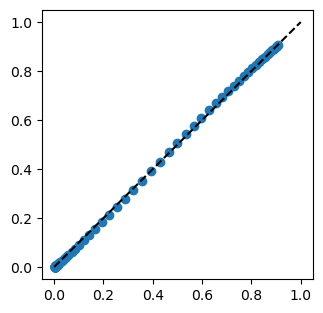

In [34]:
# dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA
mRNA_arr_myownss = kbasal_scaled + kmax_scaled * (TF_arr ** n) / ((Kd_scaled ** n) + (TF_arr ** n)) / kdegR

fig = plt.figure(figsize=(3.5,3.5))
ax = fig.add_subplot(111)
ax.scatter(mRNA_arr, mRNA_arr_myownss, label='mRNA steady state')
ax.plot([0,1],[0,1], color='black', linestyle='--')

In [35]:
10 ** np.array([ 1.99808507,  1.99928015, -4.70403039, -2.02145841,  0.24940268,  1.00970832,
 -0.05090171,  0.97277723, -0.21002087,  4.45014782, -2.20458915, -0.01435324,
  3.09376181, -0.08697834,  2.79903705, -0.15769042, -0.41878567,  3.83585522])
# k_alpha, k_beta, kbasal_scaled, kmax_scaled, 
# n, Kd_scaled, KI_PDC, nI_PDC, 
# mu_max_invert, k_trans_Rep, K_Rep, n_Rep, 
# k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp,
#  n_Amp, k_trans_PDC_amp

array([9.95600417e+01, 9.98343857e+01, 1.97683131e-05, 9.51790992e-03,
       1.77583528e+00, 1.02260596e+01, 8.89402386e-01, 9.39241406e+00,
       6.16565372e-01, 2.81934238e+04, 6.24325178e-03, 9.67490613e-01,
       1.24097151e+03, 8.18505609e-01, 6.29559889e+02, 6.95519931e-01,
       3.81253931e-01, 6.85259745e+03])

In [36]:
# assert False

# EL222 Parameters
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 1000 / koff
k_beta = koff 

# k_alpha = 4.59274930e+01
# k_beta = 1.39925875e+00
kbasal_scaled = 1.97683131e-05
kmax_scaled = 9.51790992e-03
n = 1.77583528e+00
Kd_scaled = 1.02260596e+01

EL222Pars = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

# Common Parameters
# kdegR = 0.042116
# kdegP = 12 / np.log(2) * 60
kdegPPDC = 12 / np.log(2) * 60
Ks = 0.1
Y = 0.5
nI_PDC = 2
KI_PDC = 1

KI_PDC = 8.89402386e-01
nI_PDC = 9.39241406e+00

commonPars = kdegPPDC, Ks, Y, KI_PDC, nI_PDC

# Invert Parameters
kdeg_Rep = 2 / np.log(2) * 60
K_Rep = 0.01
n_Rep = 0.7
mu_max_invert = 1
k_trans_Rep = (mu_max_invert + kdeg_Rep) * 10
k_trans_PDC_invert = (mu_max_invert + kdegPPDC) * 1

mu_max_invert = 6.16565372e-01
k_trans_Rep = 2.81934238e+04
K_Rep = 6.24325178e-03
n_Rep = 9.67490613e-01
k_trans_PDC_invert = 1.24097151e+03

invertPars = mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert

# Amp Parameters
kdeg_Amp = 2 / np.log(2) * 60
K_Amp = 0.4
mu_max_amp = 1.
n_Amp = 0.8
k_trans_Amp = mu_max_amp + kdeg_Amp
k_trans_PDC_amp = (mu_max_amp + kdegPPDC) * 5

mu_max_amp = 8.18505609e-01
k_trans_Amp = 6.29559889e+02
K_Amp = 6.95519931e-01
n_Amp = 3.81253931e-01
k_trans_PDC_amp = 6.85259745e+03

ampPars = mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp

p = EL222Pars, commonPars, ampPars, invertPars

guesses = ([1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 0, 0], [1, 1, 1, 1])

print(EL222Pars)
print(commonPars)
print(invertPars)
print(ampPars)

if True:
    lastsol = [1, 1, 1, 1]
    steady_state = []
    for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
        def rootfunc(x):
            S = 2
            X_invert = 0.01
            X_amp = 0.01
            TF = TF_fun(u)
            # print(u,TF)
            # assert False
            mRNAsetpoint = kbasal_scaled + kmax_scaled * (TF ** n) / ((Kd_scaled ** n) + (TF ** n)) / kdegR
            mRNA_invert = mRNAsetpoint
            mRNA_amp = mRNAsetpoint
            Rep, Amp, Enz_invert, Enz_amp = x
            x_in = mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
            return opto_growth(0,x_in,p, u, TF_fun)[2:-3]
        output = root(rootfunc, lastsol, tol=1e-10, method='hybr')
        if output.success is False:
            for i in range(4):
                guess = guesses[i]
                output = root(rootfunc, guess, tol=1e-10, method='hybr')
                if output.success:
                    lastsol = output.x
                    break
            if output.success is False:
                for i in range(100):
                    guess = np.random.uniform(0,1,4)
                    output = root(rootfunc, guess, tol=1e-10, method='hybr')
                    if output.success:
                        lastsol = output.x
                        break
            steady_state.append(output.x)
        else:
            lastsol = output.x
            steady_state.append(output.x)
    steady_state = np.array(steady_state)

(4.768121420056406, 0.34393, 1.97683131e-05, 0.00951790992, 1.77583528, 10.2260596, 0.042116)
(1038.7404294400537, 0.1, 0.5, 0.889402386, 9.39241406)
(0.818505609, 629.559889, 173.1234049066756, 0.695519931, 0.967490613, 1240.97151)
(0.793367928, 605.394164, 173.1234049066756, 0.686349513, 0.381253931, 6852.59745)


100%|██████████| 101/101 [00:00<00:00, 212.76it/s]


In [37]:
Rep_ss, Amp_ss, Enz_invert_ss, Enz_amp_ss = steady_state.T
mu_amp = mu_max_amp * Enz_amp_ss * 2 / (Ks + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp_ss ** nI_PDC + 1e-10))
mu_invert = mu_max_invert * Enz_invert_ss * 2 / (Ks + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))

In [38]:
amp_data = np.array([0.120837503, 0.123422835, 0.180854158, 0.19976335, 0.212471916, 0.262908006, 0.265834766, 0.308231875, 0.300134524, 0.307690564, 0.349198597, 0.235627624, 0.328256455, 0.256070133, 0.271335288, 0.18874746, 0.170414488, 0.133141302])
amp_lights = np.array([1, 1, 3, 3, 6, 6, 8, 8, 10, 10, 10, 20, 20, 40, 40, 70, 70, 100]) / 100

invert_data = np.array([0.259118174, 0.249223514, 0.251594487, 0.163109986, 0.116035613, 0.071939681, 0.064949075, 0.089238774, 0.08784264, 1E-10, 0.0414111, 0.040288699, 0.033536204])
invert_lights = np. array([0, 0, 1, 1.667, 1.667, 5, 5, 5, 5, 100, 100, 100, 100])/100

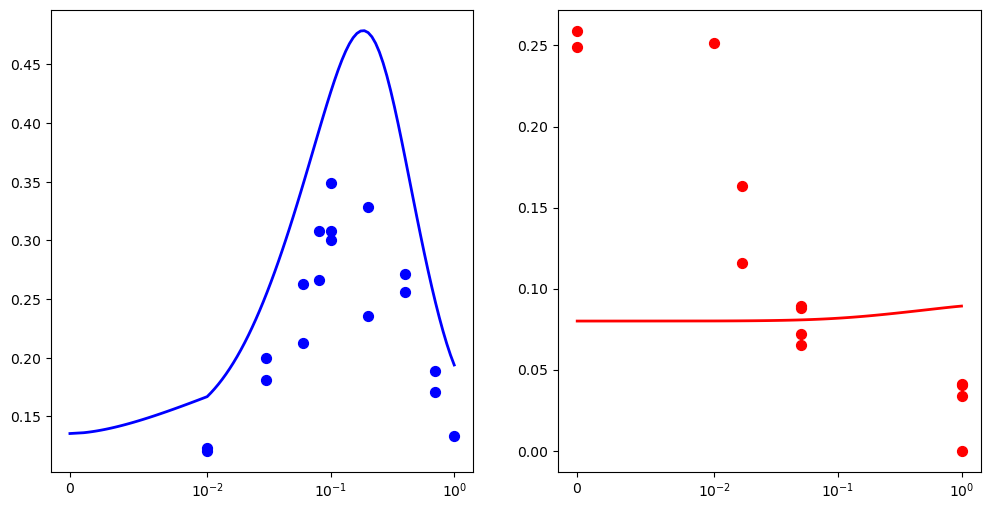

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_amp, label='Amp', color='blue', linewidth=2)
ax.scatter(amp_lights, amp_data, color='blue', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, mu_invert, label='Invert', color='red', linewidth=2)
ax.scatter(invert_lights, invert_data, color='red', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

In [11]:
def makessDoseRespCurve(p, u_input, TF_fun):
    kdegPPDC = 12 / np.log(2) * 60
    kdegR = 0.042116
    kdeg_Rep = 2 / np.log(2) * 60
    kdeg_Amp = 2 / np.log(2) * 60
    Y = 0.5
    Ks = 1
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, KI_PDC, nI_PDC, mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp = p

    EL222Pars = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR
    commonPars = kdegPPDC, Ks, Y, KI_PDC, nI_PDC
    invertPars = mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert
    ampPars = mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp
    p_in = EL222Pars, commonPars, ampPars, invertPars


    lastsol = [1, 1, 1, 1]
    steady_state = []
    for i, u in enumerate(u_input):
        def rootfunc(x):
            S = 2
            X_invert = 0.01
            X_amp = 0.01
            TF = TF_fun(u)
            # print(u,TF)
            # assert False
            mRNAsetpoint = kbasal_scaled + kmax_scaled * (TF ** n) / ((Kd_scaled ** n) + (TF ** n)) / kdegR
            mRNA_invert = mRNAsetpoint
            mRNA_amp = mRNAsetpoint
            Rep, Amp, Enz_invert, Enz_amp = x
            x_in = mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
            return opto_growth(0,x_in,p_in, u, TF_fun)[2:-3]
        output = root(rootfunc, lastsol, tol=1e-10, method='hybr')
        if output.success is False:
            for i in range(4):
                guess = guesses[i]
                output = root(rootfunc, guess, tol=1e-10, method='hybr')
                if output.success:
                    lastsol = output.x
                    break
            if output.success is False:
                for i in range(100):
                    guess = np.random.uniform(0,1,4)
                    output = root(rootfunc, guess, tol=1e-10, method='hybr')
                    if output.success:
                        lastsol = output.x
                        break
            steady_state.append(output.x)
        else:
            lastsol = output.x
            steady_state.append(output.x)
    steady_state = np.array(steady_state)
    return steady_state

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x

In [12]:

# EL222 Parameters
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 1000 / koff
k_beta = koff 

k_alpha = 4.59274930e+01
k_beta = 1.39925875e+00
kbasal_scaled = 9.60772093e-05
kmax_scaled = 4.49896402e-02
n = 1.78509721e+00
Kd_scaled = 9.99975063e+00

EL222Pars = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

# Common Parameters
# kdegR = 0.042116
# kdegP = 12 / np.log(2) * 60
kdegPPDC = 12 / np.log(2) * 60
Ks = 1
Y = 0.5
nI_PDC = 2
KI_PDC = 1

KI_PDC = 8.94579641e-01
nI_PDC = 1.00328925e+01

commonPars = kdegPPDC, Ks, Y, KI_PDC, nI_PDC

# Invert Parameters
kdeg_Rep = 2 / np.log(2) * 60
K_Rep = 0.01
n_Rep = 0.7
mu_max_invert = 1
k_trans_Rep = (mu_max_invert + kdeg_Rep) * 10
k_trans_PDC_invert = (mu_max_invert + kdegPPDC) * 1

mu_max_invert = 1.29586951e+00
k_trans_Rep = 1.63442641e+04
K_Rep = 6.38750128e-03
n_Rep = 7.21581267e-01
k_trans_PDC_invert = 9.04015902e+02

invertPars = mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert

# Amp Parameters
kdeg_Amp = 2 / np.log(2) * 60
K_Amp = 0.4
mu_max_amp = 1.
n_Amp = 0.8
k_trans_Amp = mu_max_amp + kdeg_Amp
k_trans_PDC_amp = (mu_max_amp + kdegPPDC) * 5

mu_max_amp = 7.93367928e-01
k_trans_Amp = 6.05394164e+02
K_Amp = 6.86349513e-01
n_Amp = 3.86036936e-01
k_trans_PDC_amp = 6.82544686e+03

ampPars = mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp

p = EL222Pars, commonPars, ampPars, invertPars

orig_pars =  k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, KI_PDC, nI_PDC, mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp

p_guess = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, KI_PDC, nI_PDC, mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp
bounds = (0, np.inf)



steady_state  = makessDoseRespCurve(p_guess, u_arr, TF_fun)

In [13]:
k_trans_PDC_amp

6825.44686

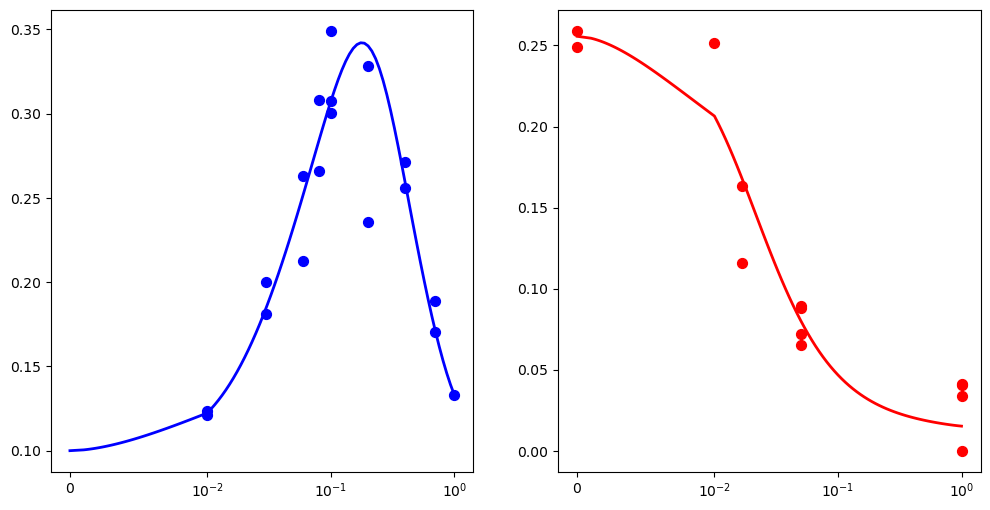

In [14]:
Rep_ss, Amp_ss, Enz_invert_ss, Enz_amp_ss = steady_state.T
mu_amp = mu_max_amp * Enz_amp_ss * 2 / (Ks + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp_ss ** nI_PDC + 1e-10))
mu_invert = mu_max_invert * Enz_invert_ss * 2 / (Ks + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_amp, label='Amp', color='blue', linewidth=2)
ax.scatter(amp_lights, amp_data, color='blue', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, mu_invert, label='Invert', color='red', linewidth=2)
ax.scatter(invert_lights, invert_data, color='red', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

In [15]:
def opto_growth_turbid(t,x,p,u,TF_fun, od_sp=0, S0=2):
        # print(p)
        # assert False    

    # Parameters
    EL222Pars, commonPars, ampPars, invertPars = p
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = EL222Pars
    kdegPPDC, Ks, Y, KI_PDC, nI_PDC = commonPars
    mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp = ampPars
    mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert = invertPars

    x_guess = x
    global setpoint

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x
    # S = np.max(S,0)
    # Enz_invert = np.max((Enz_invert,0))
    # Enz_amp = np.max((Enz_amp,0))
    # Rep = np.max((Rep,0))
    # Amp = np.max((Amp,0))

    if S > 0:
        mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert ** nI_PDC + 1e-10))
        mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp ** nI_PDC + 1e-10))
    else:
        mu_x_invert = 0
        mu_x_amp = 0

    # Dilution Rate
    total_od = X_invert + X_amp
    d = 0
    if od_sp > 0:
        if total_od > od_sp:
            d = (mu_x_invert * X_invert + mu_x_amp * X_amp) / total_od
        # else:
            # d = (mu_x_invert + mu_x_amp) * 0.1


    TF = TF_fun(u)
    mRNAsetpoint = kbasal_scaled + kmax_scaled * (TF ** n) / ((Kd_scaled ** n) + (TF ** n)) / kdegR

    dmRNA_invert_dt = (mRNAsetpoint - mRNA_invert) / tau_mRNA
    dmRNA_amp_dt = (mRNAsetpoint - mRNA_amp) / tau_mRNA

    
    dRepdt = k_trans_Rep * mRNA_invert * S / (Ks + S) - (kdeg_Rep + mu_x_invert) * Rep
    dEnz_invert_dt = k_trans_PDC_invert * (K_Rep ** n_Rep / (K_Rep ** n_Rep + Rep ** n_Rep)) * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert

    
    dAmpdt = k_trans_Amp * mRNA_amp * S / (Ks + S) - (kdeg_Amp + mu_x_amp) * Amp
    dEnz_amp_optodt = k_trans_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp

    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp + d * (S0 - S)

    if X_invert > 0: dX_invert_dt = mu_x_invert * X_invert - d * X_invert 
    else: dX_invert_dt = 0
    
    if X_amp > 0: dX_amp_dt = mu_x_amp * X_amp - d * X_amp 
    else: dX_amp_dt = 0

    # names = ['mRNA_invert', 'mRNA_amp', 'Rep', 'Amp', 'Enz_invert', 'Enz_amp', 'S', 'X_invert', 'X_amp']
    # for var, name in zip([mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp], names):
    #     if var<0:
    #         print('BIOOPY', name)
    #         assert False

    output = [dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dX_invert_dt, dX_amp_dt]
    if t>5:
        a = 2

    return output

In [16]:
def fsolve_initcond(init, p,u,TF_fun):
    X_invert = 0.01
    X_amp = 0.01
    S = 1
    od_sp = 0.02
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp = init

    init = mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp

    return opto_growth_turbid(0,init,p,u,TF_fun,od_sp)[:-3]

u=0.1
sol = root(fsolve_initcond, [1,1,1,1,1,1], args=(p,u,TF_fun), method='hybr', tol=1e-10)
print(sol.x)
print(sol.success)
print(sol.message)

initial_cond = np.concatenate((sol.x, [2, 0.0, 0.1]))

[0.00237709 0.00237709 0.11218807 0.00415241 0.0488454  0.40141945]
True
The solution converged.


In [17]:
# initial_cond = np.concatenate((sol.x, [2, 0.0, 1]))
od_sp = 0.001
u_arr = [0.1, 0, 0.1]
t0 = 0
t = np.linspace(0, 40, 1000)

mRNA_arr = []
Rep_arr = []
Amp_arr = []
Enz_invert_arr = []
Enz_amp_arr = []
S_arr = []
X_invert_arr = []
X_amp_arr = []
t_arr = []

for u in u_arr:
    t = np.linspace(0, 100, 1000) + t0
    sol = solve_ivp(opto_growth_turbid, [t[0], t[-1]], initial_cond, args=(p,u,TF_fun,od_sp), t_eval=t, method='BDF', atol=1e-9, rtol=1e-6, first_step=0.01, max_step=0.1)
    t0 = t[-1]
    initial_cond = sol.y[:,-1]
    mRNA_arr.append(sol.y[0,:])
    Rep_arr.append(sol.y[2,:])
    Amp_arr.append(sol.y[3,:])
    Enz_invert_arr.append(sol.y[4,:])
    Enz_amp_arr.append(sol.y[5,:])
    S_arr.append(sol.y[6,:])
    X_invert_arr.append(sol.y[7,:])
    X_amp_arr.append(sol.y[8,:])
    t_arr.append(sol.t)

mRNA_arr = np.hstack(mRNA_arr)
Rep_arr = np.hstack(Rep_arr)
Amp_arr = np.hstack(Amp_arr)
Enz_invert_arr = np.hstack(Enz_invert_arr)
Enz_amp_arr = np.hstack(Enz_amp_arr)
S_arr = np.hstack(S_arr)
X_invert_arr = np.hstack(X_invert_arr)
X_amp_arr = np.hstack(X_amp_arr)
t_arr = np.hstack(t_arr)

In [18]:
X_amp_arr.shape

(3000,)

Text(0.5, 1.0, 'Enz_invert')

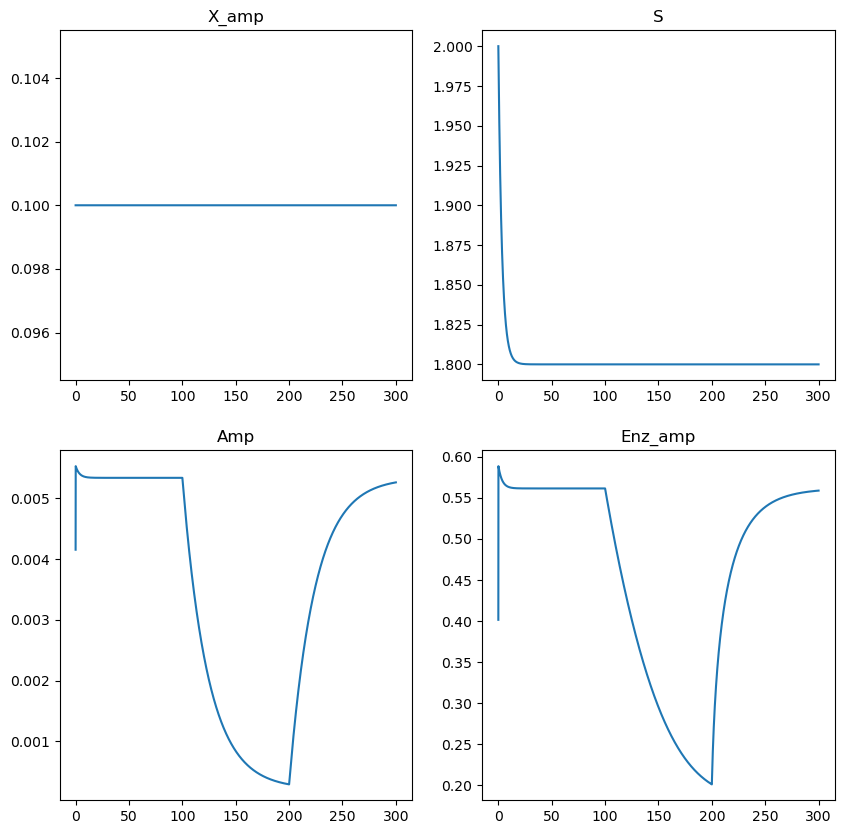

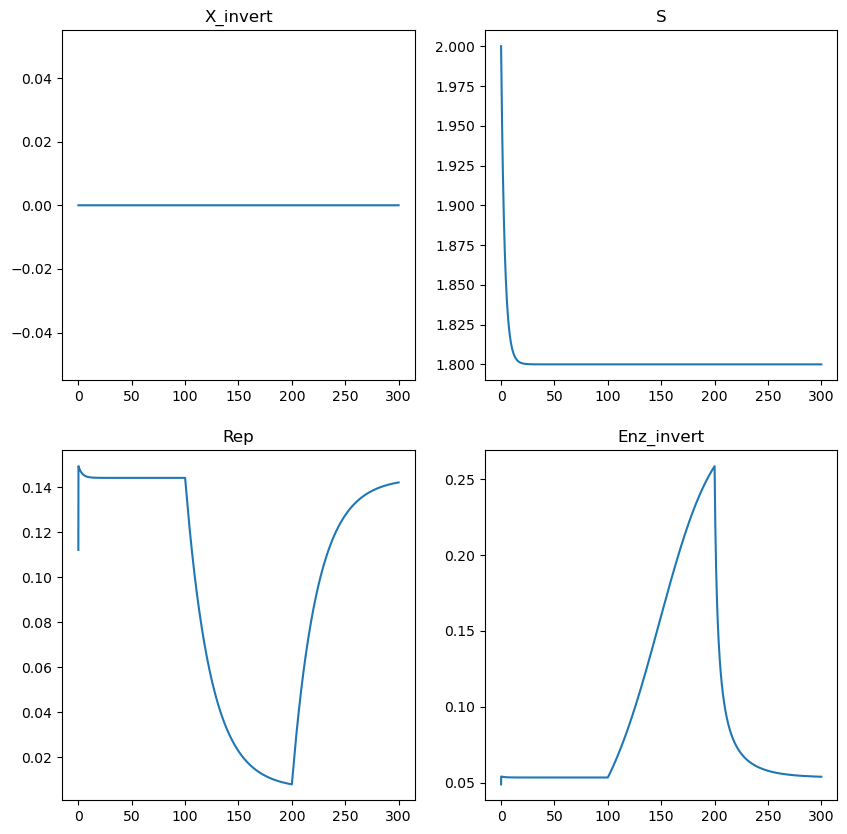

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(221)
ax.plot(t_arr, X_amp_arr, label='X_amp')
ax.set_title('X_amp')

ax = fig.add_subplot(222)
ax.plot(t_arr, S_arr, label='S')
ax.set_title('S')

ax = fig.add_subplot(223)
ax.plot(t_arr, Amp_arr, label='Amp')
ax.set_title('Amp')

ax = fig.add_subplot(224)
ax.plot(t_arr, Enz_amp_arr, label='Enz_amp')
ax.set_title('Enz_amp')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(221)
ax.plot(t_arr, X_invert_arr, label='X_amp')
ax.set_title('X_invert')

ax = fig.add_subplot(222)
ax.plot(t_arr, S_arr, label='S')
ax.set_title('S')

ax = fig.add_subplot(223)
ax.plot(t_arr, Rep_arr, label='Amp')
ax.set_title('Rep')

ax = fig.add_subplot(224)
ax.plot(t_arr, Enz_invert_arr, label='Enz_amp')
ax.set_title('Enz_invert')